# Awesome spectral indices

[Paper](asi.pdf) 

[Package](https://github.com/awesome-spectral-indices/spyndex)

In [1]:
import spyndex
import xarray as xr
import matplotlib.pyplot as plt
from rasterio import plot

## Exploring Spectral indices

In [10]:
# All indices
print(spyndex.indices)

['AFRI1600', 'AFRI2100', 'ANDWI', 'ARI', 'ARI2', 'ARVI', 'ATSAVI', 'AVI', 'AWEInsh', 'AWEIsh', 'BAI', 'BAIM', 'BAIS2', 'BCC', 'BI', 'BITM', 'BIXS', 'BLFEI', 'BNDVI', 'BRBA', 'BWDRVI', 'BaI', 'CCI', 'CIG', 'CIRE', 'CSI', 'CSIT', 'CVI', 'DBI', 'DBSI', 'DPDD', 'DSI', 'DSWI1', 'DSWI2', 'DSWI3', 'DSWI4', 'DSWI5', 'DVI', 'DVIplus', 'DpRVIHH', 'DpRVIVV', 'EBBI', 'EMBI', 'EVI', 'EVI2', 'ExG', 'ExGR', 'ExR', 'FCVI', 'GARI', 'GBNDVI', 'GCC', 'GDVI', 'GEMI', 'GLI', 'GM1', 'GM2', 'GNDVI', 'GOSAVI', 'GRNDVI', 'GRVI', 'GSAVI', 'GVMI', 'IAVI', 'IBI', 'IKAW', 'IPVI', 'IRECI', 'LSWI', 'MBI', 'MBWI', 'MCARI', 'MCARI1', 'MCARI2', 'MCARI705', 'MCARIOSAVI', 'MCARIOSAVI705', 'MGRVI', 'MIRBI', 'MLSWI26', 'MLSWI27', 'MNDVI', 'MNDWI', 'MNLI', 'MRBVI', 'MSAVI', 'MSI', 'MSR', 'MSR705', 'MTCI', 'MTVI1', 'MTVI2', 'MuWIR', 'NBAI', 'NBLI', 'NBLIOLI', 'NBR', 'NBR2', 'NBRSWIR', 'NBRT1', 'NBRT2', 'NBRT3', 'NBRplus', 'NBSIMS', 'NBUI', 'ND705', 'NDBI', 'NDBaI', 'NDCI', 'NDDI', 'NDGI', 'NDGlaI', 'NDII', 'NDISIb', 'NDISIg'

In [51]:
# NDVI index
print(spyndex.indices.NDVI)

MSAVI: Modified Soil-Adjusted Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: 0.5*(2.0*N+1-(((2*N+1)**2)-8*(N-R))**0.5)
        * Reference: https://doi.org/10.1016/0034-4257(94)90134-1
        


In [16]:
# NDVI formula
print(spyndex.indices.NDVI.formula)

(N-R)/(N+R)


In [35]:
# NDVI reference
print(spyndex.indices.NDVI.reference)

https://doi.org/10.1016/0034-4257(94)00114-3


## Vegetation indices computation

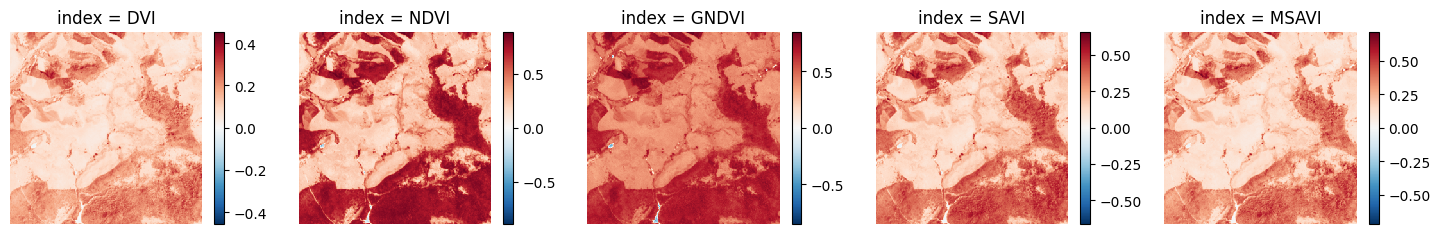

In [56]:
# Open a dataset (in this case a xarray.DataArray)
snt = spyndex.datasets.open("sentinel")

# Scale the data (remember that the valid domain for reflectance is [0,1])
snt = snt / 10000

# Compute the desired spectral indices
idx = spyndex.computeIndex(
    index = ["DVI", "NDVI", "GNDVI", "SAVI", "MSAVI"],
    params = {
        "N": snt.sel(band = "B08"),
        "R": snt.sel(band = "B04"),
        "G": snt.sel(band = "B03"),
        "L": 0.5
    }
)

# Plot the indices
fig, ax = plt.subplots(1, 5, figsize = (18,2.5))

idx.sel(index = "DVI").plot(ax = ax[0])
ax[0].set_axis_off()

idx.sel(index = "NDVI").plot(ax = ax[1])
ax[1].set_axis_off()

idx.sel(index = "GNDVI").plot(ax = ax[2])
ax[2].set_axis_off()

idx.sel(index = "SAVI").plot(ax = ax[3])
ax[3].set_axis_off()

idx.sel(index = "MSAVI").plot(ax = ax[4])
ax[4].set_axis_off()